In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
import scipy
import scipy.sparse
import scipy.sparse.linalg
import sklearn as sklearn
#Load data into the memory
data = pd.read_csv('data.csv')  # inside the name of the file with the data
print(data.head()) #let us see the first five rows
# We skip data cleaning and we pass to data collection
# we convert data to a matrix
data = np.array(data) # you will lose name of rows and columns, it keeps just the data
print(data.shape) #datasets usually are very big

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

# PCA and LDA comparison.
The task for this exercise is to compare PCA and LDA in their ability to cluster when projecting very
high-dimensional datapoints to 2 or 3 dimensions. In particular, consider the dataset MNIST provided on
Virtuale. This dataset contains images of handwritten digits with dimension 28×28, together with a number
from 0 to 9 representing the label. You are asked to:
• Load the dataset in memory and explore its head and shape to understand how the informations are
placed inside of it;

In [3]:
X = data[:, 1:] #all except first column-> the one with index
Y = data[:, 0] #all the rows and just the first column

print(X.shape, Y.shape)
#the final dimension if you look at theory must be dxN, so we have to switch the dimensions
# so I just have to transpose
X = X.T
print(X.shape)
d, N =X.shape

(42000, 784) (42000,)
(784, 42000)


Extract all the digits labeled $l$.

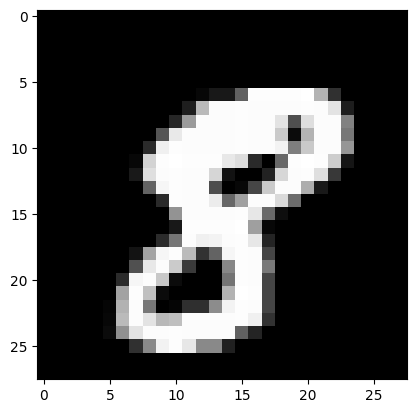

In [4]:
import matplotlib.pyplot as plt

#Load images in memory
#plt.imshow()   # NEW FUNCTION

#if I want the 10th image
#it extracts a column-> a flatten matrix, we have to do the opposite of flattening which is reshaping
idx= 10
img = X[:, idx] #all the rows and just the idx column
img = np.reshape(img, (28, 28))

#Visualize
plt.imshow(img, cmap='gray') #pixels are converted in grey scale

Choose a number of digits (for example, 0, 6 and 9) and extract from X and Y the sub-dataset containing only the considered digits. Re-call X and Y those datasets, since the originals are not required anymore;

 Set Ntrain < N and randomly sample a training set with Ntrain datapoints from X (and the corresponding Y ). Call them Xtrain and Ytrain. Everything else is the test set. Call it Xtest and Ytest.

In [5]:
# Find the corresponding indexes
I1 = (Y==0) #the index where we have the digit 0
I2 = (Y==6)
I3 = (Y==9)

# Split X and Y into X1, X2, X3 and Y1, Y2, Y3
X1 = X[:, I1]
X2 = X[:, I2]
X3 = X[:, I3]

Y1 = Y[I1]
Y2 = Y[I2]
Y3 = Y[I3]

# we have to concatenate x1, x2, x3
X = np.concatenate((X1, X2, X3), axis = 1)
Y = np.concatenate((Y1, Y2, Y3))

def split_data(X, Y, Ntrain):
    #d dimension of the image, N number of data
    d, N = X.shape

    idx = np.arange(N) #creo un vettire da 0 a N-1
    np.random.shuffle(idx) #it doesn't return anything

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx] #we take only the columns depending on the indexes
    Ytrain = Y[train_idx]

    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

#Test it
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, 3_000)
print(Xtrain.shape, Xtest.shape)



(784, 3000) (784, 9457)


In [6]:
#def compute_class_centroids(X, y):
    # Order the dataset following y
    #labels = np.unique(y) #finds the unique elements in the array y -> digits labels
    #labels.sort() #in this way they are in the correct order
    #nl = len(labels)

    #versione che occupa molta memoria
    #X_temp = []
    #for l in labels:
    #     X_temp.append(X[:, y==l])


   # X_temp = np.array([X[:, y==i] for i in range(nl)])

    # Compute the centroids
    #c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    #return c_k

In [7]:
# versione che ottimizza la memoria utilizzata

def compute_class_centroids(X, y, k):
    return np.mean(X[:, y==k], axis = 1)


In [8]:
def convert_centroids_to_dict(labels, Z_c):
    Z_c_dict = {}
    for temp in zip(labels, Z_c.T):
        l, zc = temp
        Z_c_dict[str(l)] = zc
    return Z_c_dict

Implement the algorithms computing the PCA and LDA of Xtrain with a fixed k. Visualize the results
(for k = 2) and the position of the centroid of each cluster;

In [9]:

def PCA(X, y, k):
    c_k = compute_class_centroids(X, y)
    #c_k = compute_class_centroids(X, y, [0, 6, 9])
    print(c_k)

    # Center the matrix
    cx = np.array([np.mean(col) for col in X])

    X_c = (X.T - cx).T

    U, _, _ = np.linalg.svd(X_c, full_matrices=False) # U_k in R^(d*k)
    U_k = U[:,:k]

    Z = U_k.T @ X_c
    Z_c = convert_centroids_to_dict(np.unique(y), U_k.T @ c_k.T)

    return Z, Z_c, U_k.T

Z_PCA, Z_PCA_c, U_kt = PCA(Xtrain, Ytrain, 2)
Z_PCA.shape, Z_PCA_c

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


((2, 3000),
 {'0': array([1381.82451922,  553.0551565 ]),
  '6': array([170.19715127, 904.04309266]),
  '9': array([-92.01898767,  69.72202639])})

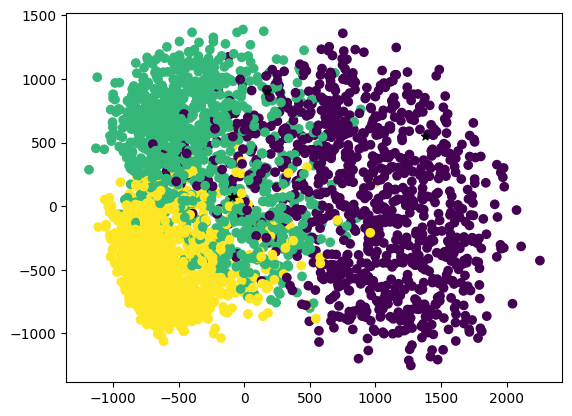

In [10]:
plt.scatter(Z_PCA[0, :], Z_PCA[1, :], c=Ytrain)
for key, val in Z_PCA_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

Alcuni centroidi risultano ai margini questo potrebbe essere dovuto al fatto che in quell'area ci sono più punti che si sovrappongono

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


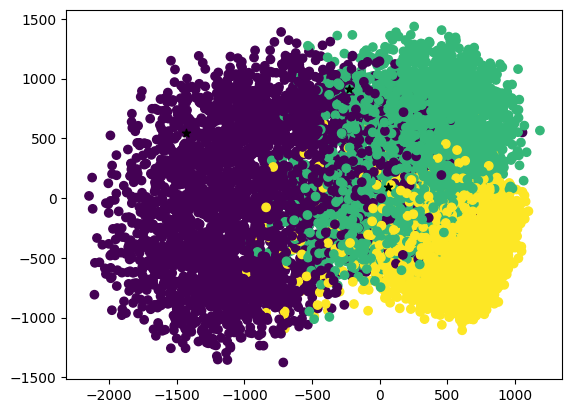

In [11]:
Z_PCA, Z_PCA_c, U_kt = PCA(Xtest, Ytest, 2)
Z_PCA.shape, Z_PCA_c

plt.scatter(Z_PCA[0, :], Z_PCA[1, :], c=Ytest)
for key, val in Z_PCA_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

In [12]:
def LDA(X, y, k):
    # Order the dataset following y
    labels = np.unique(y)
    labels.sort()
    nl = len(labels)
    X_temp = []
    for l in labels:
        X_temp.append(X[:, y==l])

    # Compute the centroids
    c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    c = np.mean(X, axis=1)

    # Center the class matrices
    X_w = X_temp[0] - c_k[0].reshape((-1, 1))
    for i in range(1, nl):
        X_w = np.concatenate((X_w, X_temp[i] - c_k[i].reshape((-1, 1))), axis=1)

    # Compute S_w
    S_w = X_w @ X_w.T

    # Compute S_b
    X_bar = np.repeat(c_k[0].reshape((-1, 1)), X_temp[0].shape[1], axis=1)
    for i in range(1, nl):
        X_bar_i = np.repeat(c_k[i].reshape((-1, 1)), X_temp[i].shape[1], axis=1)
        X_bar = np.concatenate((X_bar, X_bar_i), axis=1)
    X_barc = X_bar - c.reshape((-1, 1))
    S_b = X_barc @ X_barc.T

    try:
        L = np.linalg.cholesky(S_w)
    except:
        # Create a matrix to correct S_w to make it positive definite
        eps = 1e-6
        I_eps = np.eye(S_w.shape[0]) * eps
        S_w = S_w + I_eps
        # Decomposition
        L = np.linalg.cholesky(S_w)

    # Compute W
    L_inv = np.linalg.inv(L)
    eig_val, W = scipy.sparse.linalg.eigs(L_inv @ S_b @ L, k=k)
    W = np.real(W)

    # Compute Q.T
    Q_t = (L_inv.T @ W).T

    # Compute the projection of our data
    Z = Q_t @ X
    # and the centroid
    Z_c = convert_centroids_to_dict(labels, Q_t @ c_k.T)

    return Z, Q_t, Z_c
Z_LDA, Q_t, Z_LDA_c = LDA(Xtrain, Ytrain, 2)
Z_LDA.shape, Z_LDA_c

((2, 3000),
 {'0': array([ 0.00487501, -0.07736586]),
  '6': array([0.08372347, 0.01165909]),
  '9': array([-0.06420163,  0.06487978])})

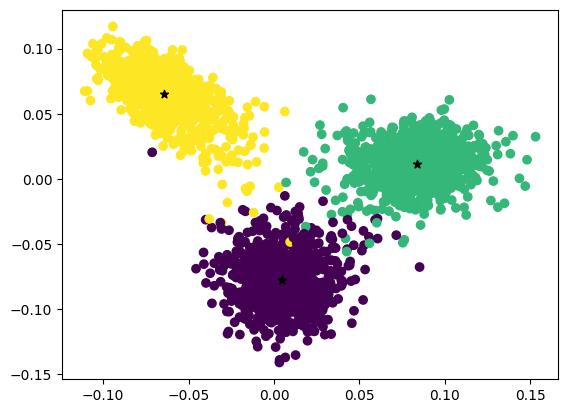

In [13]:
plt.scatter(Z_LDA[0, :], Z_LDA[1, :], c=Ytrain)
for key, val in Z_LDA_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

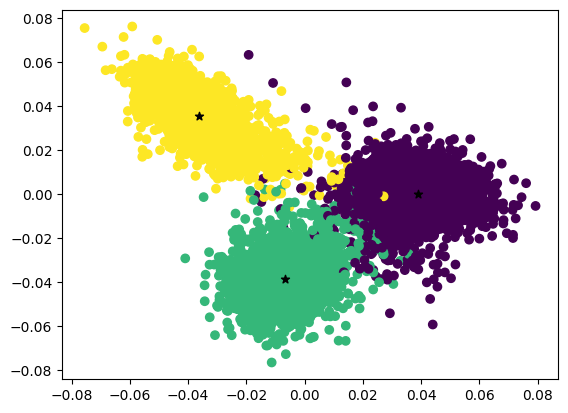

In [14]:
Z_LDAtest, Q_t, Z_LDA_c = LDA(Xtest, Ytest, 2)
Z_LDAtest.shape, Z_LDA_c

plt.scatter(Z_LDAtest[0, :], Z_LDAtest[1, :], c=Ytest)
for key, val in Z_LDA_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

In [15]:
def get_intra_cluster_dists(Z, Z_c, y):
    # Compute mean distance of the point in a cluster with the centroid
    intra_dists = {} #creo un dictionary cluster:coord
    for cluster, coord in Z_c.items():
        cluster_points = Z[:, y==int(cluster)] #considero tutti i punti appartenenti a quel cluster
        intra_dists[cluster] = np.mean(np.array([np.linalg.norm(x - Z_c[cluster]) for x in cluster_points.T])) #calcolo della distanza in media di ogni punto appartenente al cluster rispetto al centroide di quel cluster, costruisco cosi una struttura cluster:distanza in media dal centroide corrispondente
    return intra_dists

In [16]:
print(get_intra_cluster_dists(Z_PCA, Z_PCA_c, Ytest))

{'0': 993.3874224091272, '6': 886.2564825702456, '9': 815.6259336757657}


In [42]:
somma = 0
result = list(get_intra_cluster_dists(Z_PCA, Z_PCA_c, Ytest).values()) #cosi ottengo una lista di tutti i valori presenti
intra_dist2 = {}
for i in range(len(result)):
    somma = somma + result[i]
for cluster, coord in Z_PCA_c.items():
        cluster_points = Z_PCA[:, Ytest==int(cluster)] #considero tutti i punti appartenenti a quel cluster
        intra_dist2[cluster] = np.mean(np.array([np.linalg.norm(x - Z_PCA_c[cluster]) for x in cluster_points.T])) /somma
print(intra_dist2)


{'0': 0.36856696430246805, '6': 0.3288192038732797, '9': 0.30261383182425233}


fai la somma dei tre e poi divido ciascuno dei tre per la somma per avere un confronto con LDA sotto

In [17]:
Z_LDA_test = Q_t @ Xtest
get_intra_cluster_dists(Z_LDA_test, Z_LDA_c, Ytest)

{'0': 0.012669556389479185,
 '6': 0.011620586123569109,
 '9': 0.012040811896560658}

In [18]:
print(get_intra_cluster_dists(Z_LDA, Z_LDA_c, Ytrain))

{'0': 0.08666274295002344, '6': 0.10491869112290622, '9': 0.04468435429881806}


Compute the distance from the centroids on the test set

For both the algorithms, compute for each cluster the average distance from the centroid. Comment
the result;


In [19]:
# Center the matrix
X_test_centered = np.array([np.mean(col) for col in Xtest])
X_test_centered = (Xtest.T - X_test_centered).T

Z_PCA_test = U_kt @ X_test_centered
get_intra_cluster_dists(Z_PCA_test, Z_PCA_c, Ytest)


{'0': 993.3874224091272, '6': 886.2564825702456, '9': 815.6259336757657}

For both the algorithms, compute for each cluster the average distance from the centroid on the test
set. Comment the results;

In [20]:
#questo mi serve perchè voglio assegnare x alla classe a cui corrisponde il centroide più vicino
def find_nearest_centroid(point, centroid_dict):
    #tengo traccia delle distanze ottenute dai vari centroidi e dei corrispondenti labels
    #anche questo poteva essere fatto con un dictionary o va comunque ottimizzato che c'è sempre il probelma delle liste
    distance_v = []
    labels = []
    for k in centroid_dict.keys(): #ciclo nella lista dei miei centroidi
        distance_v.append(np.linalg.norm(centroid_dict[k] - point))
        labels.append(k)

    return int(labels[distance_v.index(min(distance_v))]) #prendo il label corrispondente alla minima distanza trovata

In [21]:
# con questa funzione calcolo il cluster più vicino ai punti considerati
# considero tutti i punti in Z (si richiedeva di generare un nuovo set x quindi non importa come lo crei non è specificato)
# ciclo per tutti i punti presenti nel nuovo dataset x e calcolo i cluster corrispondenti che poi dovrò andare a confrontare con i cluster reali per vedere a quanto ammonta il discostamento
def generic_classifier(Z_c, T_matrix, X_test):
    Z = T_matrix @ X_test
    # Find the nearest centroid
    y_predicted = []
    for point in Z.T:
        y_predicted.append(find_nearest_centroid(point, Z_c))

    return np.array(y_predicted)

In [22]:
def PCA_classifier(X_train, y_train, X_test, k=2):
    _, Z_PCA_c, U_kt = PCA(X_train, y_train, k=k)
    # Center the matrix
    X_test_centered = np.array([np.mean(col) for col in X_test])
    X_test_centered = (X_test.T - X_test_centered).T
    return generic_classifier(Z_PCA_c, U_kt, X_test_centered)

In [23]:
def LDA_classifier(X_train, y_train, X_test, k=2):
    _, Q_t, Z_LDA_c = LDA(X_train, y_train, k=k)
    return generic_classifier(Z_LDA_c, Q_t, X_test)

In [24]:
def compute_accuracy(y_true, y_guess):
    return (len(y_true) - np.count_nonzero(y_true - y_guess)) / len(y_true) * 100

In [25]:
for k in range(2, 30, 2):
    y_predicted = PCA_classifier(Xtrain, Ytrain, Xtest, k=k)
    print("acc with k = "+ str(k) + ": " + str(compute_accuracy(Ytest, y_predicted)) + " %")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 2: 63.244157766733636 %
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 4: 88.15692079940784 %
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 6: 88.8442423601565 %
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 8: 88.40012689013429 %
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 10: 88.75964893729513 %
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 12: 89.00285502802157 %
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 14: 89.04515173945225 %
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 16: 89.11917098445595 %
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
acc with k = 18: 89.1931

Define a classification algorithm in this way: given a new observation x, compute the distance between
x and each cluster centroid. Assign x to the class corresponding the the closer centroid. Compute the
accuracy of this algorithm on the test set and compute its accuracy for both PCA and LDA;

In [26]:
for k in range(1, 9, 1):
    y_predicted = LDA_classifier(Xtrain, Ytrain, Xtest, k=k)
    print("acc with k = "+ str(k) + ": " + str(compute_accuracy(Ytest, y_predicted)) + " %")

#Fai il plot degli error...

acc with k = 1: 90.93792957597546 %
acc with k = 2: 97.04980437770963 %
acc with k = 3: 96.76430157555251 %
acc with k = 4: 96.98635931056361 %
acc with k = 5: 96.85946917627155 %
acc with k = 6: 96.73257904197948 %
acc with k = 7: 96.85946917627155 %
acc with k = 8: 96.80659828698319 %


LDA si stabilizza piu velocemente

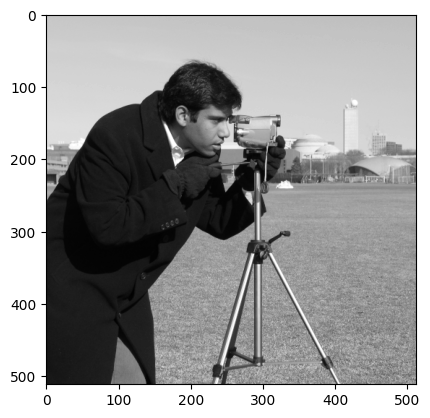

In [27]:
import skimage.data
import matplotlib.pyplot as plt
from skimage import color

X = skimage.data.camera()
plt.imshow(X, cmap="gray")
plt.show()

In [28]:
import numpy as np
# Compute SVD
svd_m = np.linalg.svd(X, full_matrices=False)
U, s, v = svd_m
U.shape, s.shape, v.shape

((512, 512), (512,), (512, 512))

In [29]:
def get_ith_dyad(i, svd_m):
    U, s, v = svd_m
    return s[i] * (U[:, i].reshape((-1, 1)) @ v[i, :].reshape((1, -1)))

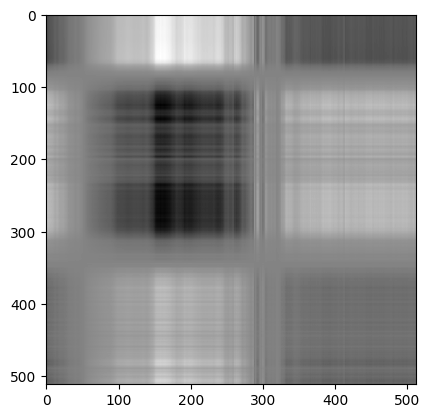

In [30]:
plt.imshow(get_ith_dyad(2, svd_m), cmap="gray")
plt.show()

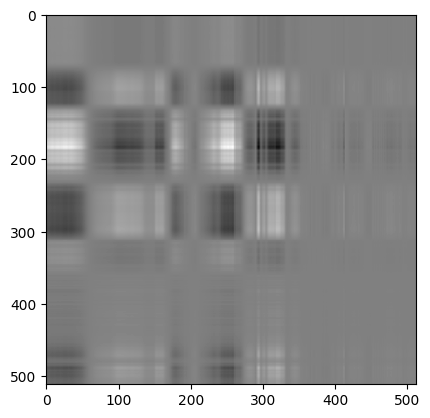

In [31]:
plt.imshow(get_ith_dyad(3, svd_m), cmap="gray")
plt.show()

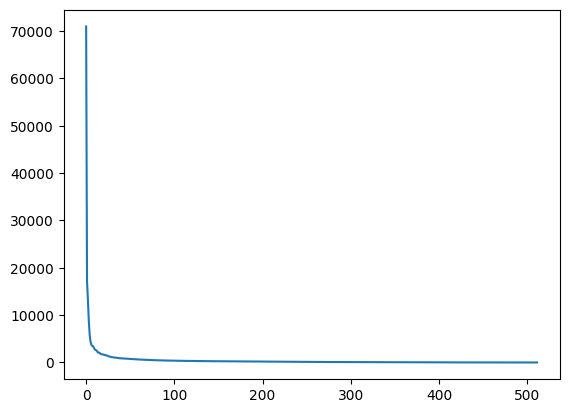

In [32]:
plt.plot(s)
plt.show()

In [33]:
def k_val_image_approximation(img, k):
    # Compute SVD
    svd_m = np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
    app_img = get_ith_dyad(0, svd_m)
    for i in range(1, k-1):
        app_img = app_img + get_ith_dyad(i, svd_m)
    return app_img

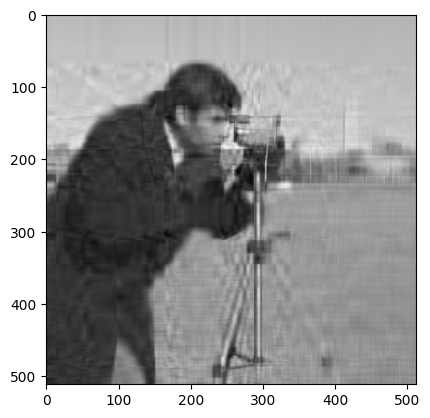

In [34]:
plt.imshow(k_val_image_approximation(X, 20), cmap="gray")
plt.show()

In [35]:
approx_range = range(1, 200, 2)
approx_error = [np.linalg.norm(X - k_val_image_approximation(X, k)) for k in approx_range]

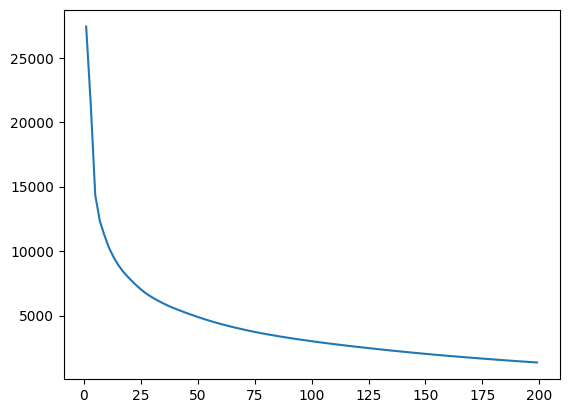

In [36]:
plt.plot([k for k in approx_range], approx_error)
plt.title("Relative error")
plt.xlabel("number of dyad used")
plt.ylabel("relative error")
plt.show()

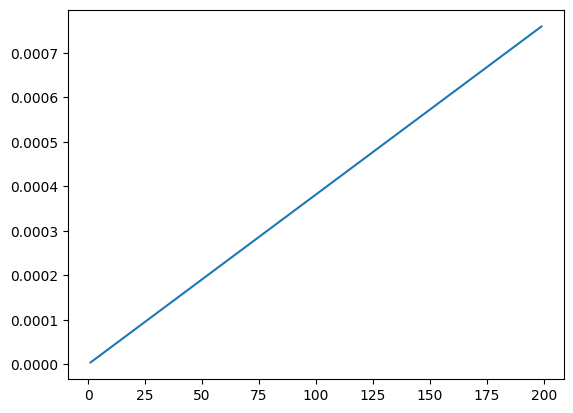

In [37]:
compression_factor = [k/(X.shape[0] * X.shape[1]) for k in approx_range]
plt.plot([k for k in approx_range], compression_factor)
plt.show()